# Rotarod Stats

Here I load the data from the spreadsheet:

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrices, dmatrix, demo_data #library to help us describe the model
%matplotlib inline

xl_file = pd.ExcelFile('Rotarod and weight.xlsx')

dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

Here I load it into some variables for plotting. Each figure shows the mean and population for the animals in that condition (silently ignores NaNs).

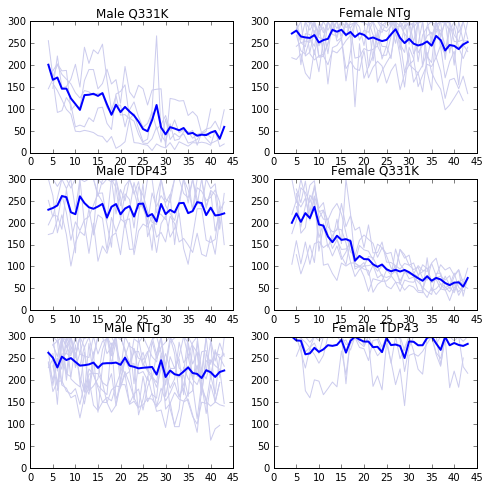

In [62]:
plt.figure(figsize=(8,8))
i = 0
for name,df in zip(dfs.iterkeys(),dfs.itervalues()):
    i += 1
    mat = df.as_matrix()
    latencies = np.array(mat[1:,1::2],dtype=np.float)
    weights = np.array(mat[1:,2::2],dtype=np.float)
    ages = np.array(mat[1:,0],np.float)
    
    plt.subplot(3,2,i)
    plt.title(name)
    plt.plot(ages,latencies,lw=1,color='#ccccee')
    plt.plot(ages,np.nanmean(latencies,axis=1),color='blue',lw=2)
    plt.ylim([0,300])
    

Here I faff about getting the data into the 'data' dictionary, each element is for one variable of interest: The mice latencies, weights, ages, ids and conditions.

I've not dealt with NaNs yet.

In [109]:
data = {'latencies':np.array([]),'weights':np.array([]),'ages':np.array([]),'animal':np.array([]),'condition':np.array([])}
#data = {'latencies':[],'weights':[],'ages':[],'animal':[],'condition':[]}
condition_idx = 0
animal_idx = 0
for name,df in zip(dfs.iterkeys(),dfs.itervalues()):
    all_latencies = np.zeros(0)
    all_weights = np.zeros(0)
    all_ages = np.zeros(0)
    all_animals = np.zeros(0)
    all_conditions = np.zeros(0)
    mat = df.as_matrix()
    latencies = np.array(mat[1:,1::2],dtype=np.float)
    weights = np.array(mat[1:,2::2],dtype=np.float)
    ages = np.array(mat[1:,0],np.float)
    
    num_animals = latencies.shape[1]
    for animal in range(num_animals):
        all_latencies = np.hstack([all_latencies,latencies[:,animal]])
        all_weights = np.hstack([all_weights,weights[:,animal]])
        all_ages = np.hstack([all_ages,ages])
        all_animals = np.hstack([all_animals,[str(animal_idx)]*len(ages)])
        animal_idx += 1
        
    #data['latencies'].append(all_latencies)
    #data['weights'].append(all_weights)
    #data['ages'].append(all_ages)
    #data['animal'].append(all_animals)
    #data['condition'].append(np.ones(len(all_animals))*idx)
    
    data['latencies'] = np.hstack([data['latencies'],all_latencies])
    data['weights'] = np.hstack([data['weights'],all_weights])
    data['ages'] = np.hstack([data['ages'],all_ages])
    data['animal'] = np.hstack([data['animal'],all_animals])
    data['condition'] = np.hstack([data['condition'],[name]*len(all_animals)])
    condition_idx+=1

Here I've plotted the design matrix (truncated somewhat) produced by patsy.

Note the first few columns are the coding of the animal ("Patsy uses a reduced-rank contrast code (treatment coding by default)").

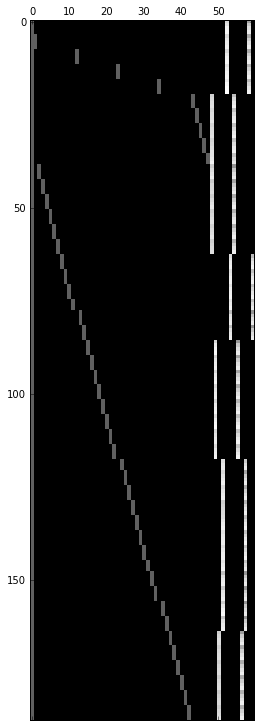

In [110]:
design = dmatrix("weights:condition + ages:condition + animal", data)
plt.matshow(np.log(0.1+np.asarray(design))[0::10,:],cmap='gray')

Here I have a go at running the actual linear regression on the data.

The coefficients we get are:

 - Intercept: the constant that describes the whole cohort of animals mean (i.e. how long on average they all stay up for)
 - animal[cond][T.1]..etc these describe offsets for each animal (i.e. how much better or worse each mouse is on average compared to the pop average).
 - weights[cond]: this describes the amount that the model thinks the latency changes, given a change in the animal's weight.
 - ages[cond]: this describes the amount the model thinks the latency changes, for a change in the animal's age.

You can see estimates for the coefficents below.

The thing that has to happen next is we need to compare the coefficients. I think we do that by using a 'contrast' (in fMRI speak). E.g. we could take the weight coefficient for one mouse and subtract the weight coefficient for another mouse, then divide this by the estimated standard deviation (to do a t-test). I'm very vague about this though.

In [111]:
y, X = dmatrices("latencies ~ weights:condition + ages:condition + animal", data)
import statsmodels.api as sm
mod = sm.OLS(y, X)
res = mod.fit()

In [112]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:              latencies   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     155.1
Date:                Fri, 26 Aug 2016   Prob (F-statistic):               0.00
Time:                        20:57:50   Log-Likelihood:                -9196.5
No. Observations:                1857   AIC:                         1.851e+04
Df Residuals:                    1797   BIC:                         1.884e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept 

Roughly...

 - The heavier a mouse is (in all conditions except female TDP43) we find a significant reduction in the time they can stay on the rod (not correcting for multiple comparisons).
 - Older mice do significantly better in some conditions. But I don't see any that do worse with age.
 
I'm worried by the second warning "The condition number is large, 3.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems." I imagine this might be because age and weight are closely linked? And also just the large number of columns I've got in the design matrix.

I think you might be better off doing the alternative option: ANCOVA as mentioned by MASH.

-- Mike.

PS Lots of things in the model could be altered!

More info about patsy:

http://patsy.readthedocs.io/en/latest/quickstart.html